## Import Library

In [30]:
import awswrangler as wr
import pandas as pd
from contextlib import suppress
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import datetime
import matplotlib.pyplot as plt


In [31]:
## 그래프 한글 출력
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = mpl.font_manager.FontProperties(fname=path).get_name()
mpl.rc('font', family=font_name)
mpl.font_manager._rebuild()

## Load Data

In [32]:
df = wr.s3.read_csv('s3://poc-ktestate/data/raw_data/20~22_total_data.csv')

## Basic PreProcessing

In [33]:
## 공조기 데이터 층수 매핑
floor_dir = {'AHU04': 'AHU_B3F',
             'AHU05': 'AHU_1F',
             'AHU06': 'AHU_2F',
             'AHU07': 'AHU_3F',
             'AHU08': 'AHU_4F',
             'AHU09': 'AHU_5F',
             'AHU13': 'AHU_9F'}
new_columns = []
for column in list(df):
    try:
        new_columns.append('_'.join([floor_dir[column.split('_')[0]],column.split('_')[1]]))
    except:
        new_columns.append(column)
df = pd.DataFrame(columns = new_columns, data = df.values)

## 데이터 형변환
for col in list(df):
    with suppress(Exception): df[col] = df[col].astype('float')
    
## 날짜 변수 추가 (년, 월)
df['시간'] = pd.to_datetime(df['시간'])
df['year'] = df['시간'].dt.year.astype('int')
df['month'] = df['시간'].dt.month.astype('int')

In [34]:
## 단일값 제거 (모든 층수에서 댐퍼와 냉난방밸브 삭제)
single_col = []
for column in list(df):
    if df[column].nunique() == 1:
        print(column, df[column].unique())
        single_col.append(column)        
df.drop(single_col, inplace = True, axis = 1)

AHU_B3F_댐퍼 [0.]
AHU_1F_댐퍼 [0.]
AHU_2F_댐퍼 [0.]
AHU_3F_댐퍼 [0.]
AHU_4F_댐퍼 [0.]
AHU_5F_댐퍼 [0.]
AHU_9F_댐퍼 [0.]
냉온수기-2 상태 [0.]
AHU_B3F_냉난방밸브 [0.]
AHU_1F_냉난방밸브 [0.]
AHU_2F_냉난방밸브 [0.]
AHU_3F_냉난방밸브 [0.]
AHU_4F_냉난방밸브 [0.]
AHU_5F_냉난방밸브 [0.]
AHU_9F_냉난방밸브 [0.]
FCU_BG_5F_상태2 [0.]


In [35]:
## eda_floor 대상으로만 데이터 분류 진행
floor_info = sum([['B3F'], [f'{num}F' for num in range(1,11)]], [])
eda_floor = ['1F', '2F', '3F']
temp_col = list(df)

for floor in floor_info:
    if floor not in eda_floor:
        for col in list(df):
            if floor in col:
                temp_col.remove(col)
df = df[temp_col].copy()

## 데이터 1차 필터링 (EDA 결과 기반 무의미한 데이터 제외)
## CH_CHWS : 동절기에는 사용하지 않음
## 냉온수기 가스량 및 상태 : 0이 많으며 불안정한 값
## CH_HD_RET : 환수온도로서 사용하지 않음
rm_col = ['CH_CHWS온도1', 'CH_CHWS온도2', '냉온수기 가스량', '냉온수기-1 상태', 'CH_HD_RET온도']
target_feature = [col for col in list(df) if col not in rm_col]
df = df[target_feature].copy()

## Optional EDA

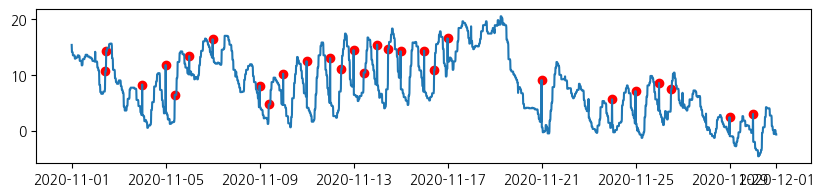

In [36]:
## 데이터가 갑자기 상승하는 데이터는 보정 필요
temp_df = df.copy()
temp_df['anomaly'] = np.where((abs(temp_df['경기대표 외기온도'] - temp_df['경기대표 외기온도'].shift(1)) > 3)
                              & (temp_df['경기대표 외기온도'] > temp_df['경기대표 외기온도'].shift(1)), 1, 0)

year = [2020]
month = [11]
temp_df = temp_df[(temp_df['year'].isin(year)) & (temp_df['month'].isin(month))]
# [1300:1450]

plt.figure(figsize = (10,2))
plt.plot(temp_df['시간'], temp_df['경기대표 외기온도'])
plt.scatter(temp_df[(temp_df['anomaly'] == 1)]['시간'], temp_df[(temp_df['anomaly'] == 1)]['경기대표 외기온도'], c = 'r')
plt.show()

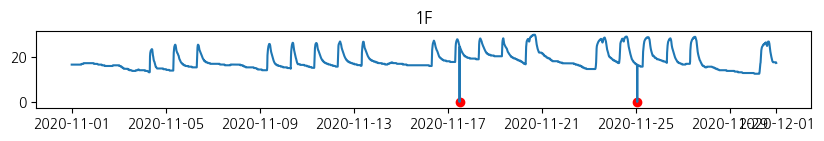

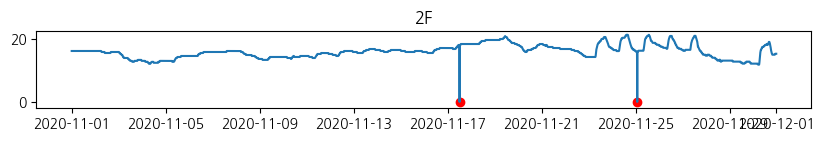

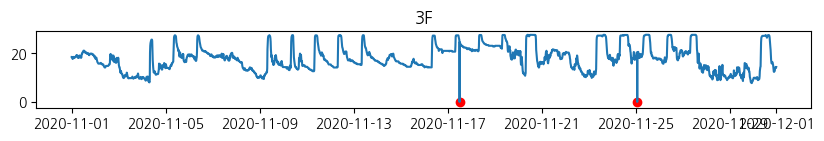

In [37]:
## 환기온도가 0인 경우는 통신이 끊겼을 때 생기는 현상으로 오류사항 (보정 필요)
temp_df = df.copy()

year = [2020]
month = [11]

for floor in eda_floor:    
    temp_df = temp_df[(temp_df['year'].isin(year)) & (temp_df['month'].isin(month))]
    plt.figure(figsize = (10,1))
    plt.plot(temp_df['시간'], temp_df[f'AHU_{floor}_환기온도'])
    plt.scatter(temp_df[temp_df[f'AHU_{floor}_환기온도'] == 0]['시간'], temp_df[temp_df[f'AHU_{floor}_환기온도'] == 0][f'AHU_{floor}_급기휀상태'], c = 'r')
    plt.title(floor)
    plt.show()       

## Data Pre-Processing

In [38]:
## 다항보간법 테스트
# temp_data = [[1],[2],[np.NaN],[2],[1.9],[4],[np.NaN],[.5],[3.7],[2],[np.NaN],[1],[1],[4],
#              [np.NaN],[5],[3],[2],[np.NaN],[1],[2.6],[np.NaN],[2.1],[1],[4],[np.NaN],[4.5],
#              [3],[2],[np.NaN],[3],[2.5],[2],[1.1],[4],[np.NaN],[4.8],[3],[2],[1],[2],[np.NaN],
#              [2],[1],[4],[np.NaN],[5],[3.8],[2],[np.NaN],[1],[1],[4],
#              [np.NaN],[5],[3],[2],[np.NaN],[1],[2],[np.NaN],[2],[1],[4],[np.NaN],[4.5],
#              [3],[2],[np.NaN],[3],[2],[2],[1],[4],[np.NaN],[4.8],[3],[2],]
# plt.figure(figsize = (5,2))
# plt.plot(pd.DataFrame(temp_data))
# plt.figure(figsize = (5,2))
# plt.plot(pd.DataFrame(temp_data).interpolate(method = 'polynomial', order = 5))
# plt.figure(figsize = (5,2))
# plt.plot(pd.DataFrame(temp_data).interpolate(method = 'polynomial', order = 2))
# plt.figure(figsize = (5,2))
# plt.plot(pd.DataFrame(temp_data).interpolate(method = 'linear', order = 2))
# plt.show()

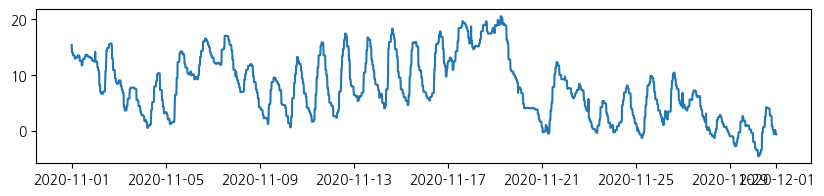

In [39]:
## 데이터가 갑자기 상승하는 데이터는 보정
temp_df = df.copy()

temp_df['경기대표 외기온도'] = np.where((abs(temp_df['경기대표 외기온도'] - temp_df['경기대표 외기온도'].shift(1)) > 3) &
                                (temp_df['경기대표 외기온도'] > temp_df['경기대표 외기온도'].shift(1)), np.NaN, temp_df['경기대표 외기온도']) ## 3도이상 상승하는 255개의 값을 NaN으로 변경
temp_df['경기대표 외기온도'] = temp_df['경기대표 외기온도'].interpolate(method = 'linear', order = 2) ## 다항식으로 NaN 보간법 진행
df = temp_df.copy() ## 변경 데이터 저장

year = [2020]
month = [11]
temp_df = temp_df[(temp_df['year'].isin(year)) & (temp_df['month'].isin(month))]
# [1300:1450]

plt.figure(figsize = (10,2))
plt.plot(temp_df['시간'], temp_df['경기대표 외기온도'])
plt.show()

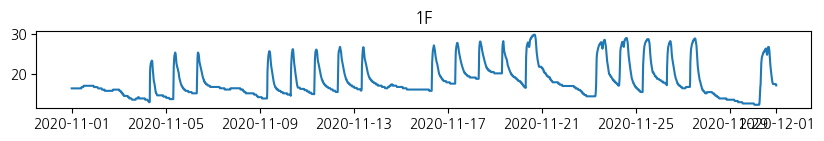

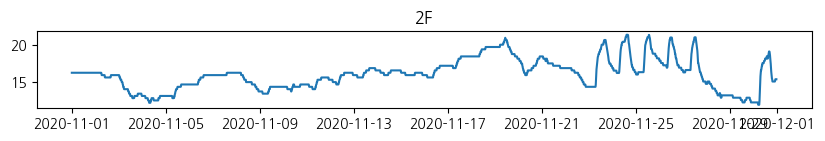

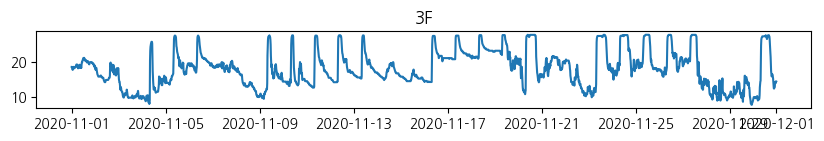

In [40]:
## 환기온도가 0인 경우는 통신이 끊겼을 때 생기는 현상으로 오류사항 (보정 필요)
temp_df = df.copy()
year = [2020]
month = [11]

for floor in eda_floor:
    temp_df[f'AHU_{floor}_환기온도'] = np.where((temp_df[f'AHU_{floor}_환기온도'] == 0) &
                               (abs(temp_df[f'AHU_{floor}_환기온도'] - temp_df[f'AHU_{floor}_환기온도'].shift(1)) > 3),
                               np.NaN, temp_df[f'AHU_{floor}_환기온도'])
    temp_df[f'AHU_{floor}_환기온도'] = temp_df[f'AHU_{floor}_환기온도'].interpolate(method = 'polynomial', order = 2) ## 다항식으로 NaN 보간법 진행    
    temp_df_2 = temp_df[(temp_df['year'].isin(year)) & (temp_df['month'].isin(month))]
    plt.figure(figsize = (10,1))
    plt.plot(temp_df_2['시간'], temp_df_2[f'AHU_{floor}_환기온도'])
    plt.title(floor)
    plt.show()    
df = temp_df.copy() ## 변경 데이터 저장

In [41]:
## Split data as floor
for floor in eda_floor:    
    globals()[f'floor_{floor}'] = []
    for column in list(df):
        if (len(column.split('_')) > 1) and (floor == column.split('_')[1]):          
            globals()[f'floor_{floor}'].append(column)
        elif (len(column.split('_')) > 2) and (floor == column.split('_')[2]):                     
            globals()[f'floor_{floor}'].append(column)
        elif (len(set(column.split('_')) & set(eda_floor)) == 0):
            globals()[f'floor_{floor}'].append(column)
    globals()[f'df_{floor}'] = df[globals()[f'floor_{floor}']].copy()    
    print(f"\n floor {floor} column num : {len(list(globals()[f'df_{floor}']))}")
    print(list(globals()[f'df_{floor}']))            
    print(globals()[f'df_{floor}'].shape)


 floor 1F column num : 17
['시간', 'AHU_1F_급기온도', 'AHU_1F_혼합온도', 'AHU_1F_환기온도', 'AHU_1F_급기휀상태', 'CH_CWR온도1', 'CH_CWR온도2', 'CH_CWS온도1', 'CH_CWS온도2', '경기대표 외기온도', 'FCU_AG_1F_상태1', 'FCU_AG_1F_상태2', 'FCU_BG_1F_상태1', 'FCU_BG_1F_상태2', 'FCU_BG_1F_상태3', 'year', 'month']
(105216, 17)

 floor 2F column num : 16
['시간', 'AHU_2F_급기온도', 'AHU_2F_혼합온도', 'AHU_2F_환기온도', 'AHU_2F_급기휀상태', 'CH_CWR온도1', 'CH_CWR온도2', 'CH_CWS온도1', 'CH_CWS온도2', '경기대표 외기온도', 'FCU_AG_2F_상태1', 'FCU_AG_2F_상태2', 'FCU_BG_2F_상태1', 'FCU_BG_2F_상태2', 'year', 'month']
(105216, 16)

 floor 3F column num : 13
['시간', 'AHU_3F_급기온도', 'AHU_3F_혼합온도', 'AHU_3F_환기온도', 'AHU_3F_급기휀상태', 'CH_CWR온도1', 'CH_CWR온도2', 'CH_CWS온도1', 'CH_CWS온도2', '경기대표 외기온도', 'FCU_BG_3F_상태', 'year', 'month']
(105216, 13)


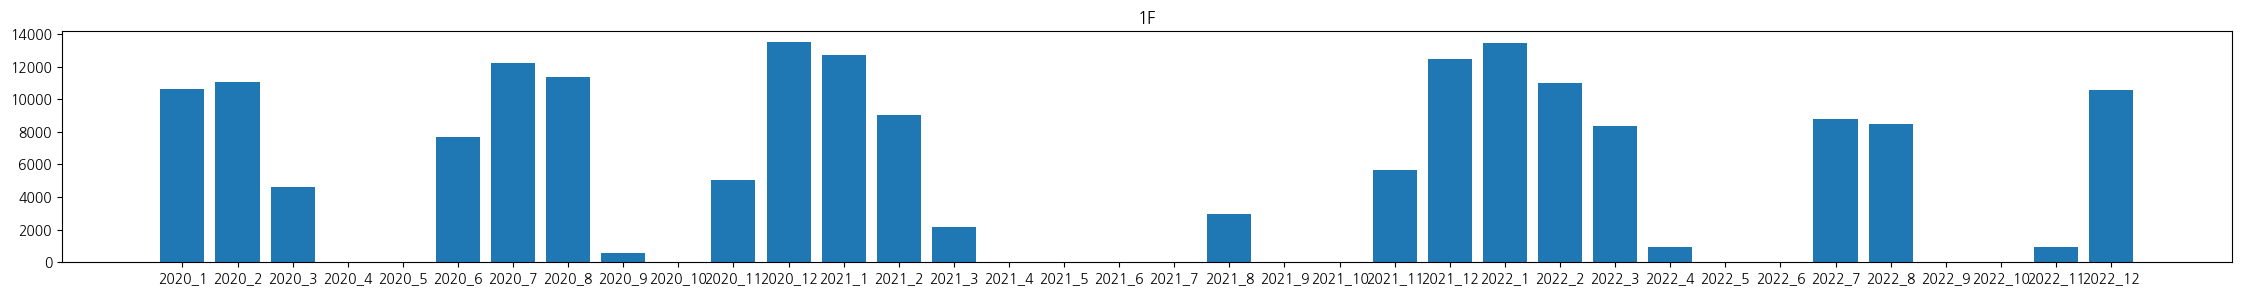

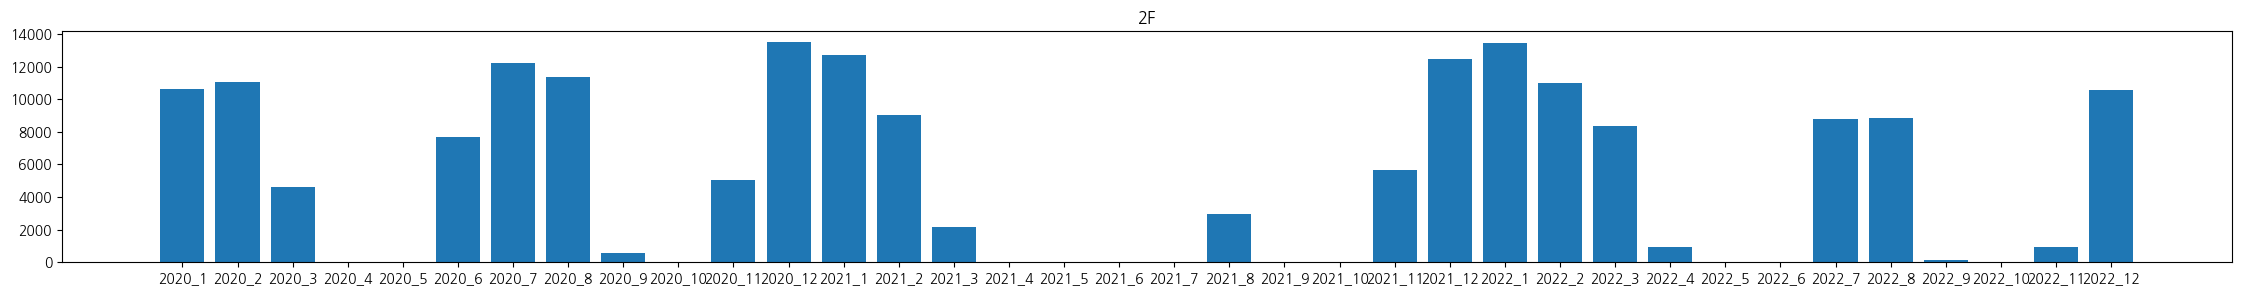

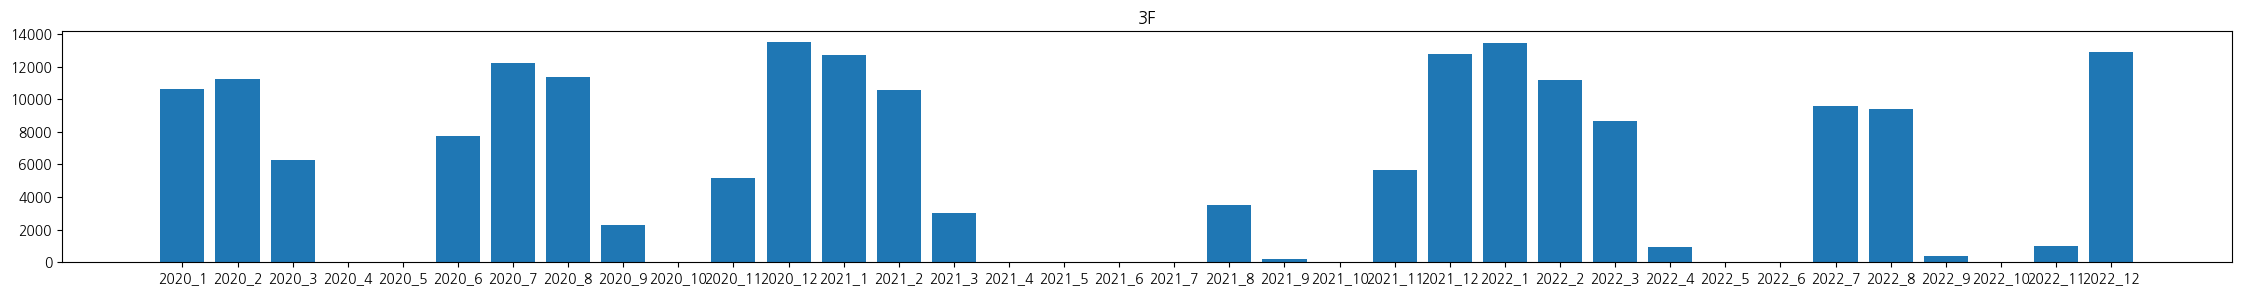

In [42]:
## Check filltering month
year_month_oper = pd.DataFrame(columns = ['year_month','month','oper'])
for floor in eda_floor:        
    temp_df = globals()[f'df_{floor}'].copy()
    temp_df['AHU_on'] = np.where((temp_df[f'AHU_{floor}_급기휀상태'] > 0) & (temp_df[[col for col in list(temp_df) if 'FCU' in col]].sum(axis =1)) > 0, 1, 0)
    temp_df = temp_df[temp_df['AHU_on'] == 1].copy()
    for year in range(2020,2023):
        for month in range(1,13):
            temp_df_2 = temp_df[(temp_df['year'] == year) & (temp_df['month'] == month)]
            year_month_oper = pd.concat([year_month_oper, pd.DataFrame([{'year_month' : str(year)+'_'+str(month),
                                                                         'month' : month,
                                                                         'oper' : temp_df_2[f'AHU_{floor}_급기휀상태'].sum()}])])
    plt.figure(figsize = (28,3))
    plt.bar(year_month_oper['year_month'], year_month_oper['oper'])
    plt.title(floor)
    plt.show()

## Data Filtering

1F
(105216, 19)


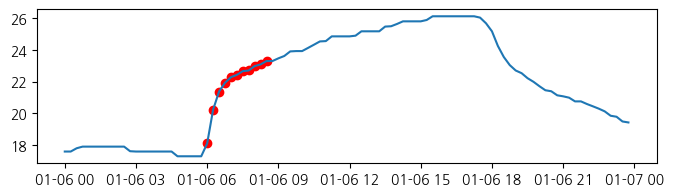

In [ ]:
for floor in eda_floor:        
    temp_df = globals()[f'df_{floor}'].copy()    
    temp_df['day'] = temp_df['시간'].dt.day
    temp_df['날짜'] = pd.to_datetime(temp_df['시간']).dt.normalize()
    print(floor)
    print(temp_df.shape)
    
    # fig_size = (10,2)    
    # year = [2020]
    # month = [1]
    # temp_df = temp_df[(temp_df['year'].isin(year))&(temp_df['month'].isin(month))]
    # temp_df = temp_df[temp_df['day'].isin([i for i in range(1,10)])]

    # ## 전체 데이터 출력
    # plt.figure(figsize = fig_size)
    # plt.plot(temp_df['시간'],temp_df[f'AHU_{floor}_환기온도'])
    # plt.show()

    ## 공조기와 냉난방기가 가동중일 때의 데이터만 필터링    
    temp_df['AHU_on'] = np.where((temp_df[f'AHU_{floor}_급기휀상태'] > 0) & (temp_df[[col for col in list(temp_df) if 'FCU' in col]].sum(axis =1)) > 0, 1, 0)    
    # plt.figure(figsize = fig_size)
    # plt.plot(temp_df['시간'],temp_df[f'AHU_{floor}_환기온도'])
    # plt.scatter(temp_df[temp_df['AHU_on'] == 1]['시간'],temp_df[temp_df['AHU_on'] == 1][f'AHU_{floor}_환기온도'], c = 'r')
    # plt.show()

    ## 상승하는 추세의 데이터만 출력
    temp_df['temper_raise'] = np.where(temp_df[f'AHU_{floor}_환기온도'] - temp_df[f'AHU_{floor}_환기온도'].shift(1) > 0, 1, 0)
    # plt.figure(figsize = fig_size)
    # plt.plot(temp_df['시간'],temp_df[f'AHU_{floor}_환기온도'])
    # plt.scatter(temp_df[(temp_df['AHU_on'] == 1) & (temp_df['temper_raise'] == 1)]['시간'],
    #             temp_df[(temp_df['AHU_on'] == 1) & (temp_df['temper_raise'] == 1)][f'AHU_{floor}_환기온도'],
    #             c = 'r')
    # plt.show()

    ## 겨울 데이터만 필터링 (1,2,3,11,12월)
    temp_df['winter'] = np.where(temp_df['month'].isin([1,2,3,11,12]), 1, 0)
    # plt.figure(figsize = fig_size)
    # plt.plot(temp_df['시간'],temp_df[f'AHU_{floor}_환기온도'])
    # plt.scatter(temp_df[(temp_df['AHU_on'] == 1) & (temp_df['temper_raise'] == 1) & (temp_df['winter'])]['시간'],
    #             temp_df[(temp_df['AHU_on'] == 1) & (temp_df['temper_raise'] == 1) & (temp_df['winter'])][f'AHU_{floor}_환기온도'],
    #             c = 'r')
    # plt.show()

    ## 감소추세 직전 데이터 필터링 (상승 후 감소하는 시점 제외)
    filter_df = pd.DataFrame()
    for date in temp_df['날짜'].unique():
        temp_df_2 = temp_df[temp_df['날짜'] == date].copy()
        temp_df_2 = temp_df_2[(temp_df_2['AHU_on'] == 1) & (temp_df_2['temper_raise'] == 1) & (temp_df_2['winter'] == 1)].reset_index(drop = True)
        
        temp_df_2['time_diff'] = temp_df_2['시간'] - temp_df_2['시간'].shift(1)
        
        temp_df_2['time_diff'] = temp_df_2['time_diff'].astype("timedelta64[m]")
        if temp_df_2[temp_df_2['time_diff'] > 15].shape[0] > 0:
            temp_df_2 = temp_df_2[temp_df_2['시간'] < temp_df_2[temp_df_2['time_diff'] > 15]['시간'].min()]    
        filter_df = pd.concat([filter_df, temp_df_2])

    plt.figure(figsize = fig_size)
    plt.plot(temp_df['시간'],temp_df[f'AHU_{floor}_환기온도'])
    plt.scatter(filter_df['시간'], filter_df[f'AHU_{floor}_환기온도'], c = 'r')
    plt.show()
    # print(filter_df.shape)
    # filter_df.to_csv(f's3://poc-ktestate/data/pre_processing_data/filter_df_{floor}.csv', index = False)

## 하루 단위 시작/끝 데이터 생성


In [82]:
def daily_start_end(data):
    data = data[data[f'AHU_{floor}_급기휀상태'] > 0]
    data['시간'] = pd.to_datetime(data['시간'])
    data['날짜'] = pd.to_datetime(data['시간']).dt.normalize()

    temper = data[data['시간'].isin(data.groupby(['날짜'])[['시간']].max()['시간'])][['날짜',f'AHU_{floor}_환기온도']].copy()
    temper.rename(columns = {f'AHU_{floor}_환기온도' : 'target_temp'}, inplace = True)
    target = data.groupby(['날짜'])[f'AHU_{floor}_급기휀상태'].sum().reset_index()
    target.rename(columns = {f'AHU_{floor}_급기휀상태' : 'operation_time'}, inplace = True)
    input_time = data.groupby(['날짜'])['시간'].min().reset_index()[['시간']]
    model_df = data[data['시간'].isin(input_time['시간'])].copy()
    model_df = pd.merge(model_df, temper, on = '날짜', how = 'left')
    model_df = pd.merge(model_df, target, on = '날짜', how = 'left')
    return model_df

## 중간 내용 고려한 데이터 생성

In [68]:
def middle_start_end(data, add_range = 50):
    total_df = pd.DataFrame()
    add_num_range = add_range

    for date in data['날짜'].unique():
        # print(f'date : {date}')
        temp_df = data[data['날짜'] == date].copy()  ## 날짜별 필터링
        temp_df.reset_index(drop = True, inplace = True)
        for num in range(add_num_range):  
            # if num%10 == 0:
                # print(f'number {num} ~ {num + 10}')
            add_num = num + 1
            for index in temp_df.index:  
                if index <= temp_df.index.max() - add_num:
                    temp_value = 0
                    for num in range(add_num):
                        temp_value += temp_df.loc[index + num + 1,f'AHU_{floor}_급기휀상태']
                    temp_df.loc[index, 'operation_time'] = temp_value
                    temp_df.loc[index, 'target_temp'] = temp_df.loc[index+add_num,f'AHU_{floor}_환기온도']
            total_df = pd.concat([total_df, temp_df])
    total_df.drop_duplicates(inplace = True)
    total_df.dropna(axis = 0, inplace = True)
    return total_df

## 학습/테스트용 데이터 저장

In [89]:
for floor in eda_floor:
    filter_df = wr.s3.read_csv(f's3://poc-ktestate/data/pre_processing_data/filter_df_{floor}.csv')
    print(filter_df.shape)
    ## Train/Test Split
    split_time = '2022-11-01'
    train_df = filter_df[filter_df['시간'] <= split_time]
    test_df = filter_df[filter_df['시간'] > split_time]
    print(f'학습 데이터 분류 : {train_df.shape}')
    print(f'테스트 데이터 분류 : {test_df.shape}')
    
    daily_df = daily_start_end(train_df)
    test_df = daily_start_end(test_df)

    daily_df.to_csv(f's3://poc-ktestate/data/train_data/daily_df_{floor}.csv', index = False)
    test_df.to_csv(f's3://poc-ktestate/data/train_data/test_df_{floor}.csv', index = False)

    print(f'{floor} floor 학습 데이터 Daily 변환 : {daily_df.shape}')
    print(f'{floor} floor 테스트 데이터 Daily 변환 : {test_df.shape}')
    
    # middle_df = middle_start_end(train_df)
    # middle_df.to_csv(f's3://poc-ktestate/data/train_data/middle_df_{floor}.csv', index = False)
    # print(f'{floor} floor 학습 데이터 Middle 변환 : {middle_df.shape}')

(2652, 23)
학습 데이터 분류 : (2389, 23)
테스트 데이터 분류 : (263, 23)
1F floor 학습 데이터 Daily 변환 : (247, 25)
1F floor 테스트 데이터 Daily 변환 : (25, 25)
(1634, 22)
학습 데이터 분류 : (1355, 22)
테스트 데이터 분류 : (279, 22)
2F floor 학습 데이터 Daily 변환 : (160, 24)
2F floor 테스트 데이터 Daily 변환 : (25, 24)
(1329, 19)
학습 데이터 분류 : (1191, 19)
테스트 데이터 분류 : (138, 19)
3F floor 학습 데이터 Daily 변환 : (244, 21)
3F floor 테스트 데이터 Daily 변환 : (25, 21)


## Model Test

In [203]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

1F floor 학습 데이터 Daily 변환 : (247, 25)
1F floor 테스트 데이터 Daily 변환 : (25, 25)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train RMSE : 13.559033575368698, MAPE : 39.59224116321025
Test RMSE : 41.469420203325726, MAPE : 25.961359014314905


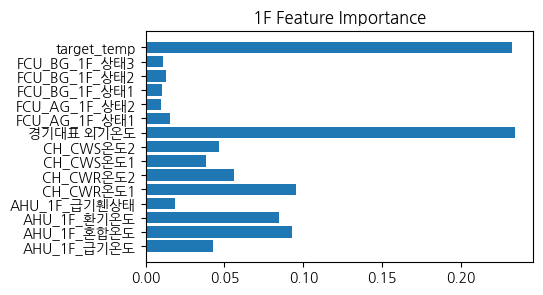

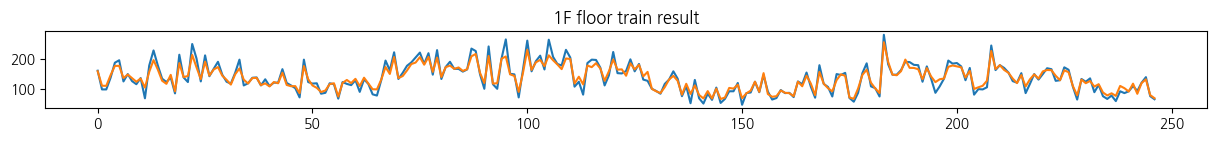

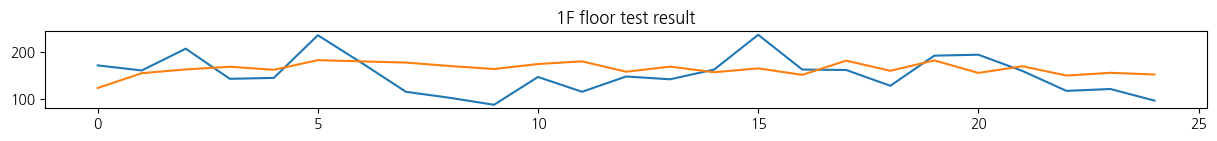

2F floor 학습 데이터 Daily 변환 : (160, 24)
2F floor 테스트 데이터 Daily 변환 : (25, 24)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train RMSE : 14.115750909887863, MAPE : 115.31490578784774
Test RMSE : 54.482856422915276, MAPE : 25.78593109825273


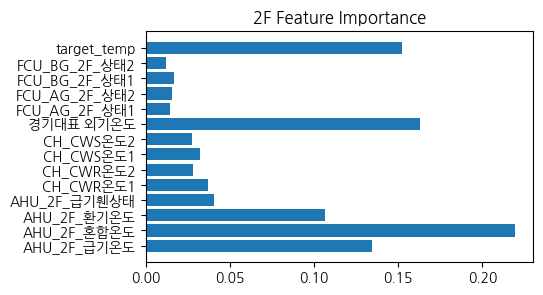

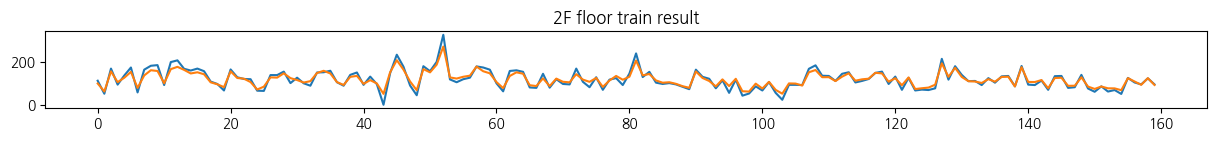

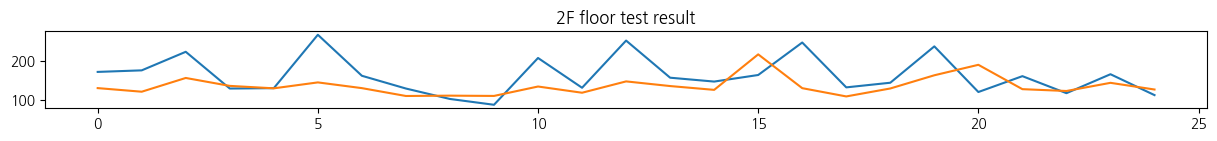

3F floor 학습 데이터 Daily 변환 : (244, 21)
3F floor 테스트 데이터 Daily 변환 : (25, 21)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train RMSE : 6.760255203010908, MAPE : 36.7919532836979
Test RMSE : 17.700083276640257, MAPE : 23.53934106609342


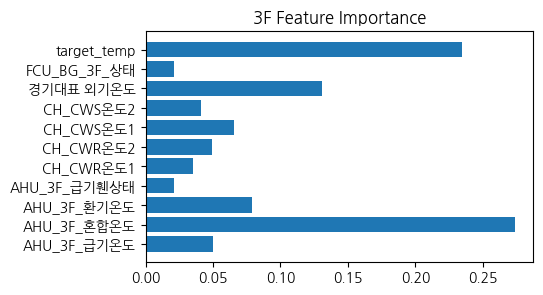

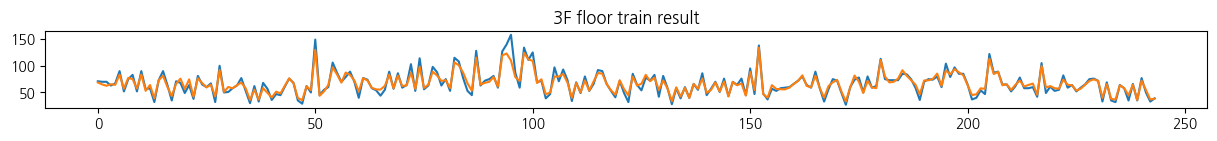

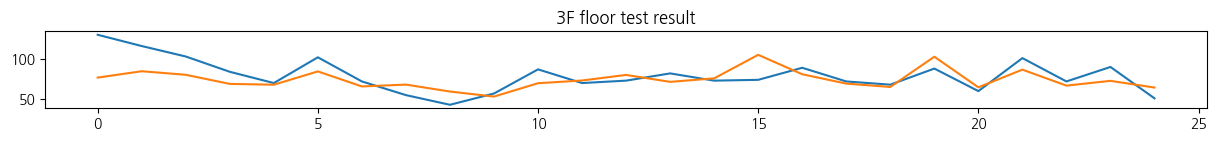

In [204]:
for floor in eda_floor:
    # floor = '1F'
    daily_df = wr.s3.read_csv(f's3://poc-ktestate/data/train_data/daily_df_{floor}.csv')
    test_df = wr.s3.read_csv(f's3://poc-ktestate/data/train_data/test_df_{floor}.csv')
    print(f'{floor} floor 학습 데이터 Daily 변환 : {daily_df.shape}')
    print(f'{floor} floor 테스트 데이터 Daily 변환 : {test_df.shape}')

    daily_df.drop(['시간','날짜','year','month','day','AHU_on','temper_raise','winter','time_diff'], axis = 1, inplace = True)
    test_df.drop(['시간','날짜','year','month','day','AHU_on','temper_raise','winter','time_diff'], axis = 1, inplace = True)
    feature_list = list(daily_df)
    feature_list.remove('operation_time')

    daily_x = daily_df[feature_list]
    daily_y = daily_df[['operation_time']]
    test_x = test_df[feature_list]
    test_y = test_df[['operation_time']]

    daily_model = RandomForestRegressor(random_state=1004).fit(daily_x, daily_y)
    
    print(f"Train RMSE : {np.sqrt(mean_squared_error(daily_y, daily_model.predict(daily_x)))}, MAPE : {mean_absolute_percentage_error(daily_y, daily_model.predict(daily_x))}")
    print(f"Test RMSE : {np.sqrt(mean_squared_error(test_y, daily_model.predict(test_x)))}, MAPE : {mean_absolute_percentage_error(test_y, daily_model.predict(test_x))}")
    
    plt.figure(figsize=(5,3))
    plt.barh(list(daily_x), daily_model.feature_importances_)
    plt.title(f'{floor} Feature Importance')
    
    plt.figure(figsize=(15,1))
    plt.plot(daily_y)
    plt.plot(daily_model.predict(daily_x))
    plt.title(f'{floor} floor train result')
    plt.show()
    
    plt.figure(figsize=(15,1))
    plt.plot(test_y)
    plt.plot(daily_model.predict(test_x))
    plt.title(f'{floor} floor test result')
    plt.show()

## , f'AHU_{floor}_급기휀상태' 뺴야되지않나??

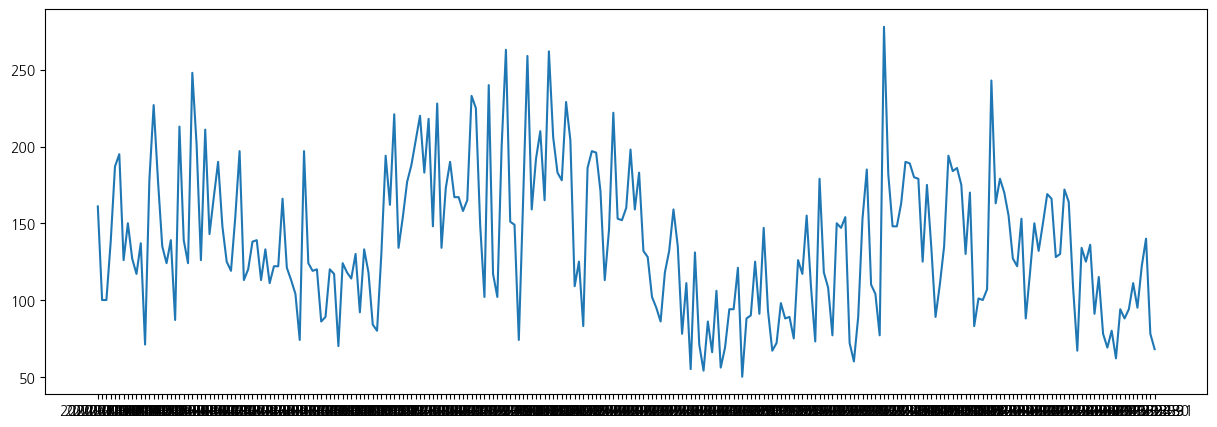

In [157]:
plt.figure(figsize=(15,5))
plt.plot(daily_df['날짜'], daily_df['operation_time'])
plt.show()

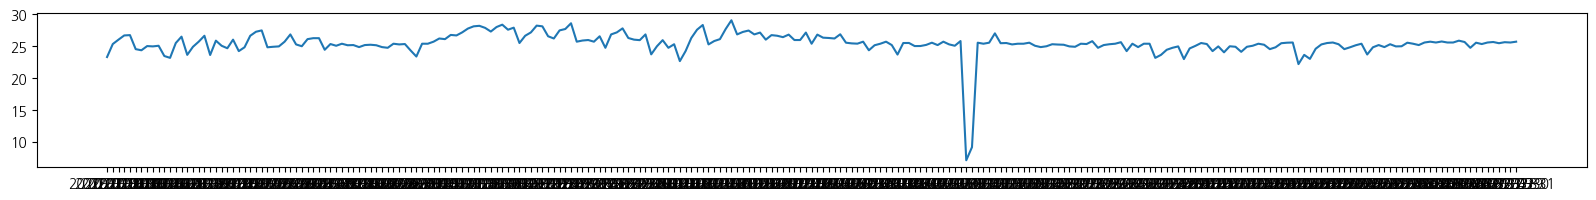

In [181]:
## 학습 데이터 이상치 파악 (급격하게 감소하는 지점 2개 존재)
min_ragne = 0
max_range = len(daily_df)

daily_df[daily_df['target_temp'] <= 10]
plt.figure(figsize=(20,2))
plt.plot(daily_df['날짜'][min_ragne:max_range], daily_df['target_temp'][min_ragne:max_range])
plt.show()

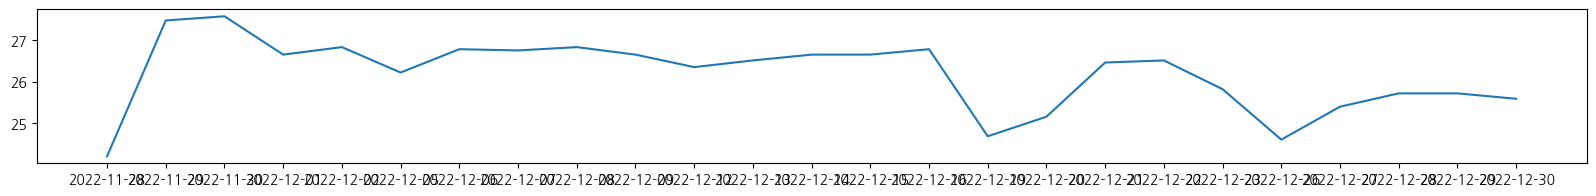

In [184]:
## 학습 데이터 이상치 파악 (급격하게 감소하는 지점 2개 존재)
min_ragne = 0
max_range = len(test_df)

plt.figure(figsize=(20,2))
plt.plot(test_df['날짜'][min_ragne:max_range], test_df['target_temp'][min_ragne:max_range])
plt.show()